In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
from torch_geometric.data import Data
import random
import json
from Sampler import flow_duration_to_float

In [2]:
categorial_to_id = {
    'Benign': 0,
    'Background': 0,
    'Bruteforce': 1,
    'Bruteforce-XML': 2,
    'Probing': 3,
    'XMRIGCC CryptoMiner': 4
}

In [3]:
with open('configs/sampler_config.json', 'r') as f:
    config = json.load(f)
    f.close()

IN_FILES = config['in_file_paths']
OUT_FILE = config['out_file_path']
NUM_SAMPLE = config['num_of_samples']
REAL_ALPHA = config['real_data_alpha']
NUM_REAL = int(NUM_SAMPLE * REAL_ALPHA)
NUM_BA = NUM_SAMPLE - NUM_REAL
FEATURES = config['features']

dfs = []
for file in IN_FILES:
    df = pd.read_csv(file, index_col=0)
    if 'traffic_category' in df.columns:
        df = df.rename(columns={"traffic_category": "attack_category"})
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)
data['flow_duration'] = data['flow_duration'].apply(lambda x: flow_duration_to_float(x))
data['Label'] = data['attack_category'].apply(lambda x: categorial_to_id[x])
data = data.dropna(axis=1)

In [24]:
data.head()

,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,attack_category,Label
0,Cg61Jch3vdz9DBptj,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,6,6,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,2
1,CdRIlqLWdj35Y9vW9,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,6,6,...,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,2
2,CLzp9Khd0Y09Qkgrg,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,6,5,...,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,2
3,Cnf1YA4iLB4CSNWB88,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,6,5,...,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,2
4,C4ZKvv3fpO72EAOsJ6,103.255.15.23,13324,128.199.242.104,443,7.780611,14,14,6,5,...,7.545305e+06,7.545305e+06,7.545305e+06,7.545305e+06,0.0,29200,65160,0,Bruteforce-XML,2


In [33]:
data.describe()

,originp,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Label
count,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,783531.000000,7.835310e+05,...,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000,783531.000000
mean,38137.784467,5807.488489,7.930232,15.141476,15.202140,6.076205,11.985713,2.457452e+03,1960.277241,4.417729e+03,...,1.153479e+05,3.233009e+06,4.344537e+06,7.002749e+06,3.663116e+06,5.879498e+05,25885.029520,26880.533083,7417.383553,0.177706
std,17985.867934,13924.299570,97.220072,390.717612,395.026085,62.401492,393.515497,2.913841e+04,5229.838478,3.047502e+04,...,6.996897e+06,1.655481e+07,2.072960e+07,9.294205e+07,1.743732e+07,6.110173e+06,24759.854726,31078.695220,17077.151387,0.717086
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,26475.000000,80.000000,0.000225,1.000000,1.000000,0.000000,0.000000,3.132429e+00,2.335226,5.642361e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,41889.000000,443.000000,0.026036,2.000000,2.000000,2.000000,2.000000,4.053486e+01,45.893094,8.477880e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200.000000,0.000000,63.000000,0.000000
75%,52534.000000,1947.000000,0.439577,10.000000,11.000000,3.000000,6.000000,8.762138e+01,84.827667,1.717218e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200.000000,65160.000000,402.000000,0.000000
max,65535.000000,65522.000000,17942.909297,326292.000000,326827.000000,3953.000000,326822.000000,3.355443e+06,524288.000000,3.355443e+06,...,5.438463e+09,2.998038e+08,2.998038e+08,1.792532e+10,2.998038e+08,2.029962e+08,65535.000000,65535.000000,65535.000000,4.000000


In [27]:
X = data[FEATURES]
y = data['Label'].to_list()

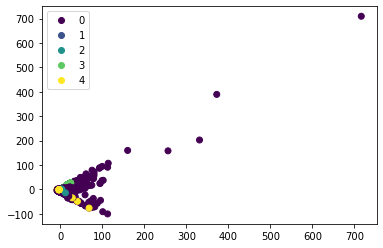

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(set(y)))
plt.show()

In [6]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

In [8]:
benign_df = data[data['attack_category']=='Benign']
benign_df_features = benign_df[FEATURES]
criteria = benign_df_features<=0.7*benign_df_features.max()

X_filtered = benign_df_features[criteria].dropna().reset_index(drop=True)
filter_mask_row = ~benign_df_features[criteria].isna().any(axis=1)
# y_filtered = [l for (l, b) in zip(y, filter_mask_row) if b]


In [154]:
normalize(X_filtered)

array([[5.77295663e-07, 1.36798073e-08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.77316446e-07, 1.36454580e-08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.77204234e-07, 1.37356613e-08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.96071831e-07, 4.95279729e-07, 0.00000000e+00, ...,
        1.15697345e-03, 0.00000000e+00, 0.00000000e+00],
       [3.96061721e-07, 4.95347982e-07, 0.00000000e+00, ...,
        1.15713289e-03, 0.00000000e+00, 0.00000000e+00],
       [3.96062806e-07, 4.95356650e-07, 0.00000000e+00, ...,
        1.28000158e-03, 0.00000000e+00, 0.00000000e+00]])

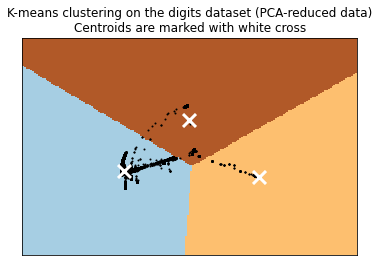

In [162]:
# benign_df_features = benign_df[FEATURES]
X_filtered_norm = normalize(X_filtered)
reduced_data = PCA(n_components=2).fit_transform(X_filtered_norm)
kmeans = KMeans(init="k-means++", n_clusters=3, n_init=3)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [4]:
from sklearn.manifold import TSNE
import seaborn as sns

In [9]:
X_filtered_norm = normalize(X_filtered)
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X_filtered_norm) 
sns.scatterplot(x=z[:,0], y=z[:,1],
                data=df).set(title="Iris data T-SNE projection") 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 197949 samples in 0.051s...
[t-SNE] Computed neighbors for 197949 samples in 63.919s...
[t-SNE] Computed conditional probabilities for sample 1000 / 197949
[t-SNE] Computed conditional probabilities for sample 2000 / 197949
[t-SNE] Computed conditional probabilities for sample 3000 / 197949
[t-SNE] Computed conditional probabilities for sample 4000 / 197949
[t-SNE] Computed conditional probabilities for sample 5000 / 197949
[t-SNE] Computed conditional probabilities for sample 6000 / 197949
[t-SNE] Computed conditional probabilities for sample 7000 / 197949
[t-SNE] Computed conditional probabilities for sample 8000 / 197949
[t-SNE] Computed conditional probabilities for sample 9000 / 197949
[t-SNE] Computed conditional probabilities for sample 10000 / 197949
[t-SNE] Computed conditional probabilities for sample 11000 / 197949
[t-SNE] Computed conditional probabilities for sample 12000 / 197949
[t-SNE] Computed conditional probab

KeyboardInterrupt: 

In [163]:
X_filtered_norm = normalize(X_filtered)

kmeans = KMeans(init="k-means++", n_clusters=3, n_init=3)
kmeans.fit(X_filtered_norm)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].
reduced_data = PCA(n_components=2).fit_transform(X_filtered_norm)
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

ValueError: X has 2 features, but KMeans is expecting 79 features as input.

In [76]:
X

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,...,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,...,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,...,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,...,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,...,1.176575e+05,126016.885411,7.545305e+06,7.545305e+06,7.545305e+06,7.545305e+06,0.0,29200,65160,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783526,0.000027,2,0,2,0,73584.280702,0.000000,73584.280702,0.000000,16,...,2.717972e+01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0
783527,0.000027,2,0,2,0,74235.469027,0.000000,74235.469027,0.000000,16,...,2.694130e+01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0
783528,0.000000,2,0,2,0,0.000000,0.000000,0.000000,0.000000,16,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0
783529,0.000054,2,0,2,0,37117.734513,0.000000,37117.734513,0.000000,16,...,5.388260e+01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,0,0


In [119]:
criteria = X<0.9*X.max()

X_filtered = X[criteria].dropna().reset_index(drop=True)
filter_mask_row = ~X[criteria].isna().any(axis=1)
y_filtered = [l for (l, b) in zip(y, filter_mask_row) if b]

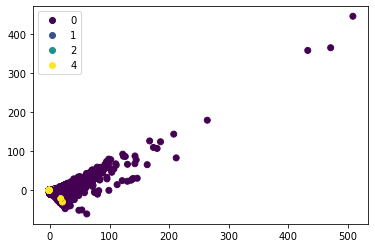

In [120]:
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(X_filtered)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_filtered)
plt.legend(handles=plot.legend_elements()[0], labels=list(set(y_filtered)))
plt.show()

In [107]:
len(X_filtered)

341712